In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import io

In [2]:

# Configuración para mejorar la visualización
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'gray'

print("="*70)
print("Muestreo, Cuantificación y Reconstrucción de Imágenes")
print("="*70)

# ==============================================================================
# CARGAR IMAGEN (Usuario puede subir su propia imagen o usar una sintética)
# ==============================================================================

print("\n¿Deseas subir tu propia imagen o usar una imagen sintética?")
print("Opciones:")
print("  1. Subir mi propia imagen")
print("  2. Usar imagen sintética generada automáticamente")

try:
    # Intentar importar google.colab para detectar si estamos en Colab
    from google.colab import files
    EN_COLAB = True
    print("\n✓ Entorno Google Colab detectado")
except ImportError:
    EN_COLAB = False
    print("\n⚠ No se detectó Google Colab. Se usará imagen sintética por defecto.")


Muestreo, Cuantificación y Reconstrucción de Imágenes

¿Deseas subir tu propia imagen o usar una imagen sintética?
Opciones:
  1. Subir mi propia imagen
  2. Usar imagen sintética generada automáticamente

⚠ No se detectó Google Colab. Se usará imagen sintética por defecto.


In [3]:

usar_imagen_propia = False

if EN_COLAB:
    opcion = input("\nIngresa tu opción (1 o 2): ").strip()

    if opcion == "1":
        print("\n📤 Por favor, sube tu imagen (formatos: JPG, PNG, BMP, etc.)")
        uploaded = files.upload()

        if uploaded:
            # Obtener el primer archivo subido
            filename = list(uploaded.keys())[0]
            print(f"\n✓ Imagen cargada: {filename}")

            # Cargar la imagen
            imagen_original = Image.open(io.BytesIO(uploaded[filename]))

            # Convertir a escala de grises si es necesario
            if imagen_original.mode != 'L':
                print("  Convirtiendo a escala de grises...")
                imagen_original = imagen_original.convert('L')

            # Convertir a numpy array
            imagen_original = np.array(imagen_original)

            # Redimensionar si es muy grande (opcional, para mejor rendimiento)
            max_size = 512
            if imagen_original.shape[0] > max_size or imagen_original.shape[1] > max_size:
                print(f"  Redimensionando imagen a máximo {max_size}x{max_size} para mejor rendimiento...")
                ratio = min(max_size / imagen_original.shape[0], max_size / imagen_original.shape[1])
                new_size = (int(imagen_original.shape[1] * ratio), int(imagen_original.shape[0] * ratio))
                img_pil = Image.fromarray(imagen_original)
                img_pil = img_pil.resize(new_size, Image.BILINEAR)
                imagen_original = np.array(img_pil)

            usar_imagen_propia = True
            print(f"✓ Imagen lista para análisis: {imagen_original.shape}")
        else:
            print("\n⚠ No se subió ninguna imagen. Usando imagen sintética.")
    else:
        print("\n✓ Usando imagen sintética")

# Si no se cargó imagen propia, crear una sintética
if not usar_imagen_propia:
    print("\n[Generando imagen sintética...]")

    # Crear una imagen sintética con patrones de diferentes frecuencias
    size = 512
    x = np.linspace(0, 4*np.pi, size)
    y = np.linspace(0, 4*np.pi, size)
    X, Y = np.meshgrid(x, y)

    # Imagen con componentes de diferentes frecuencias espaciales
    imagen_original = (np.sin(X) + np.sin(Y) +
                       0.5*np.sin(3*X) + 0.5*np.sin(3*Y) +
                       0.3*np.sin(5*X + 5*Y))

    # Normalizar a 0-255
    imagen_original = ((imagen_original - imagen_original.min()) /
                       (imagen_original.max() - imagen_original.min()) * 255).astype(np.uint8)

    print(f"✓ Imagen sintética creada: {imagen_original.shape}")

print(f"\nInformación de la imagen:")
print(f"  Dimensiones: {imagen_original.shape}")
print(f"  Rango de valores: [{imagen_original.min()}, {imagen_original.max()}]")
print(f"  Tipo de dato: {imagen_original.dtype}")



[Generando imagen sintética...]
✓ Imagen sintética creada: (512, 512)

Información de la imagen:
  Dimensiones: (512, 512)
  Rango de valores: [0, 255]
  Tipo de dato: uint8


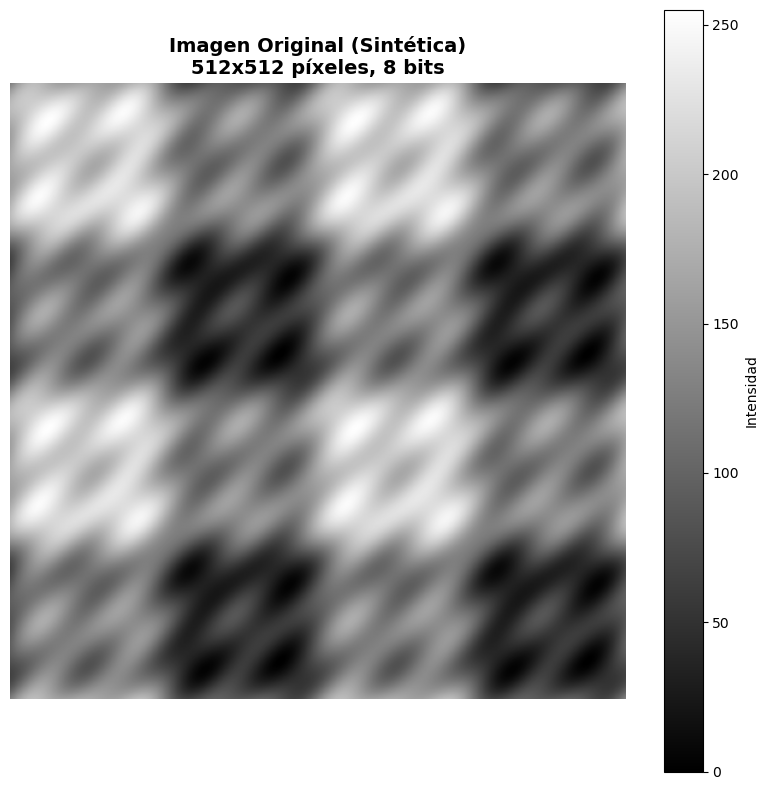


[1/5] Aplicando muestreo espacial...
✓ Imagen submuestreada x2: (256, 256)
✓ Imagen submuestreada x4: (128, 128)
✓ Imagen submuestreada x8: (64, 64)
✓ Imagen submuestreada x16: (32, 32)


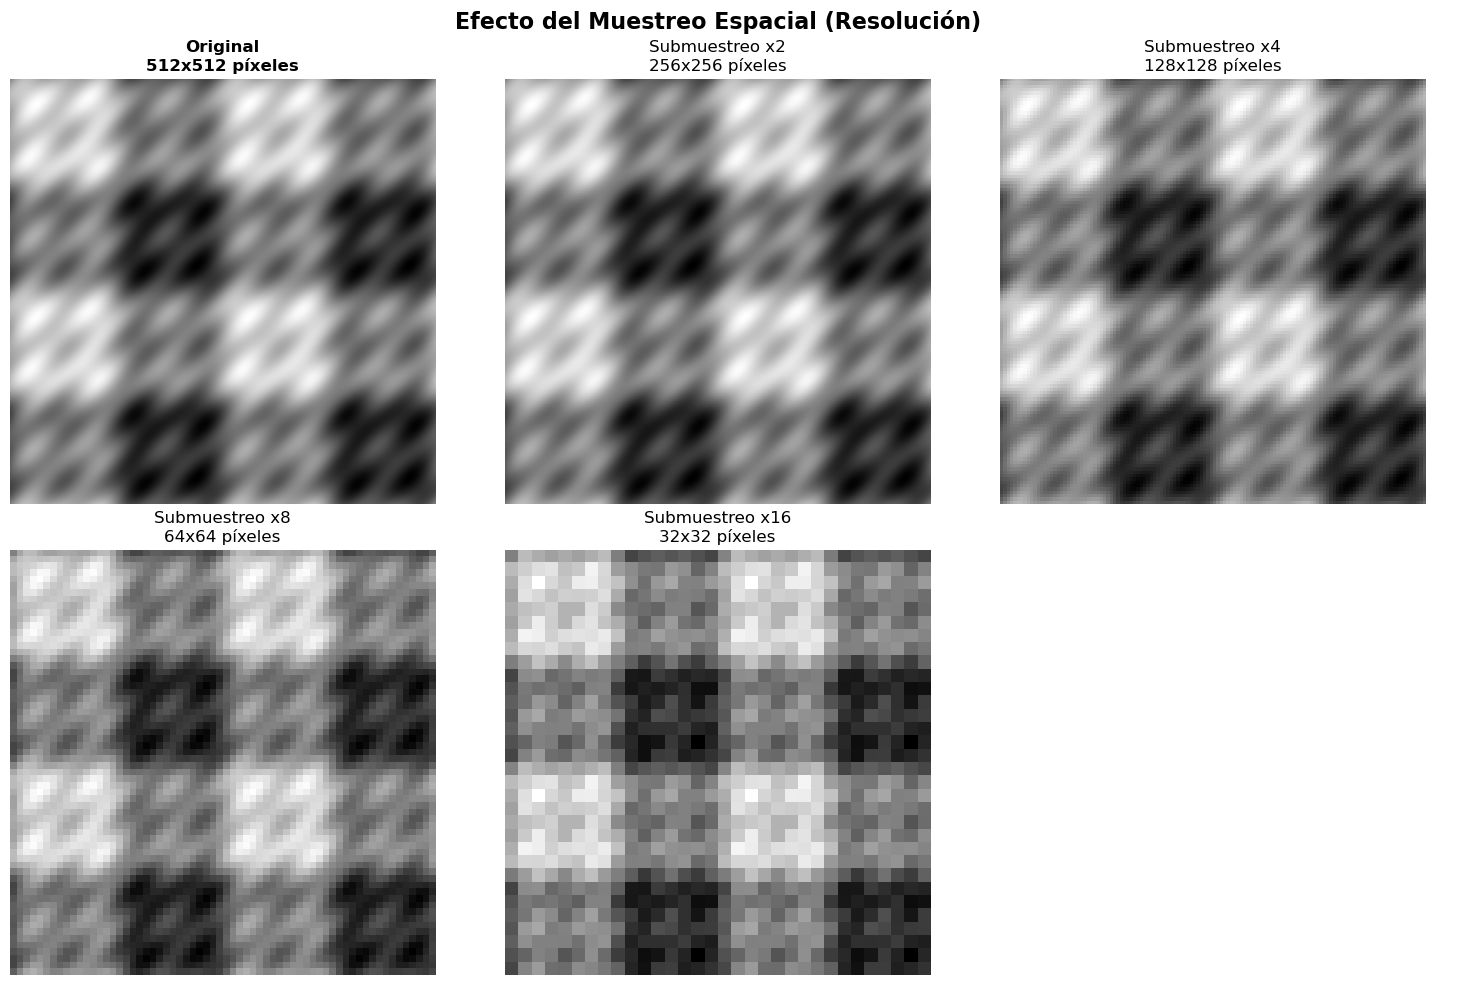


[2/5] Aplicando cuantificación de niveles de gris...
✓ 8 bits: 256 niveles únicos
✓ 6 bits: 64 niveles únicos
✓ 4 bits: 16 niveles únicos
✓ 3 bits: 8 niveles únicos
✓ 2 bits: 4 niveles únicos
✓ 1 bit: 2 niveles únicos


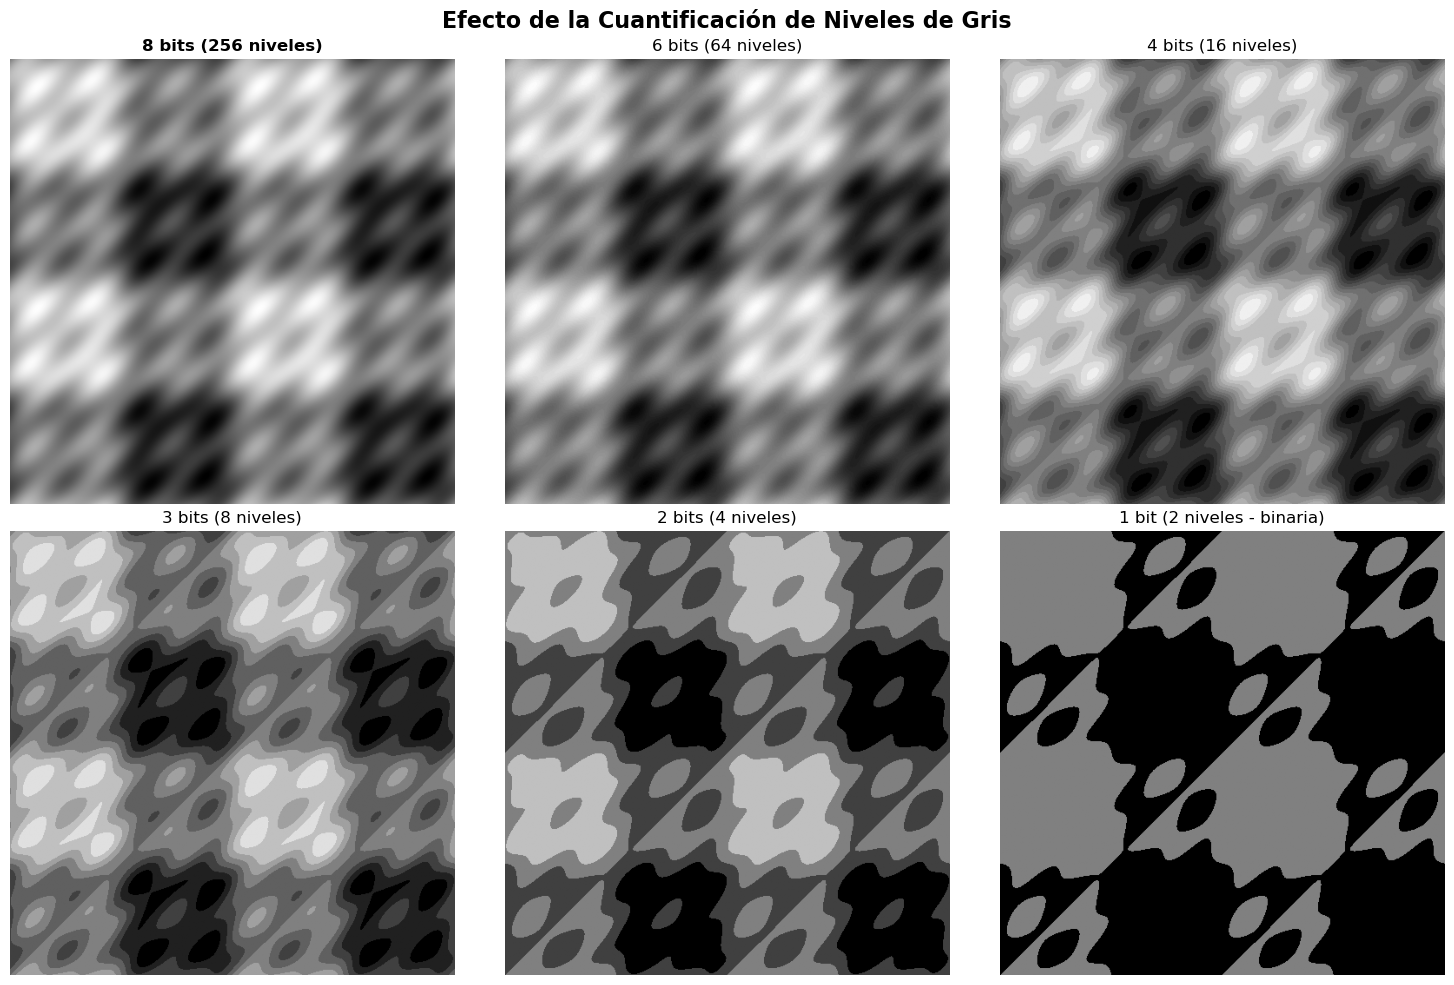


[3/5] Reconstruyendo imágenes con diferentes métodos de interpolación...
✓ Vecino más cercano: (512, 512)
✓ Bilineal: (512, 512)
✓ Bicúbica: (512, 512)


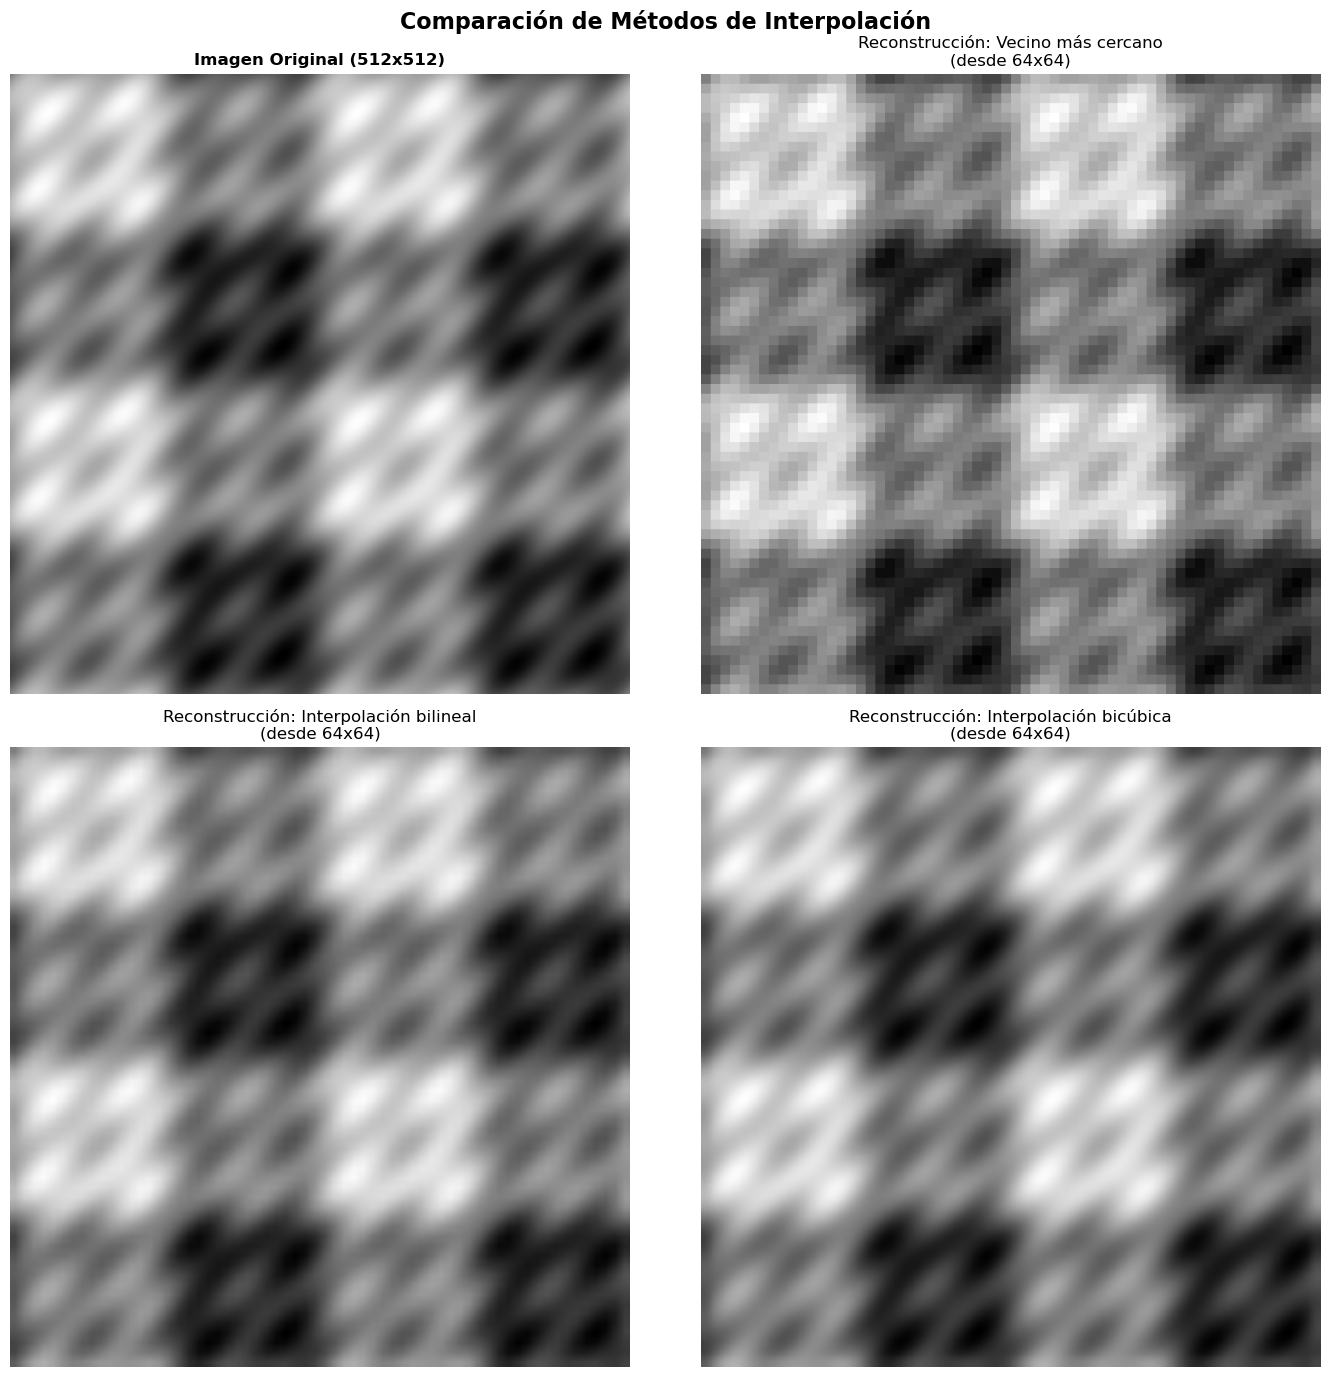


[4/5] Calculando métricas de error...

=== Métricas de Error de Reconstrucción ===

Vecino más cercano:
  MSE: 193.34
  RMSE: 13.90
  PSNR: 25.27 dB

Interpolación bilineal:
  MSE: 144.53
  RMSE: 12.02
  PSNR: 26.53 dB

Interpolación bicúbica:
  MSE: 152.56
  RMSE: 12.35
  PSNR: 26.30 dB

Nota: Mayor PSNR indica mejor calidad de reconstrucción


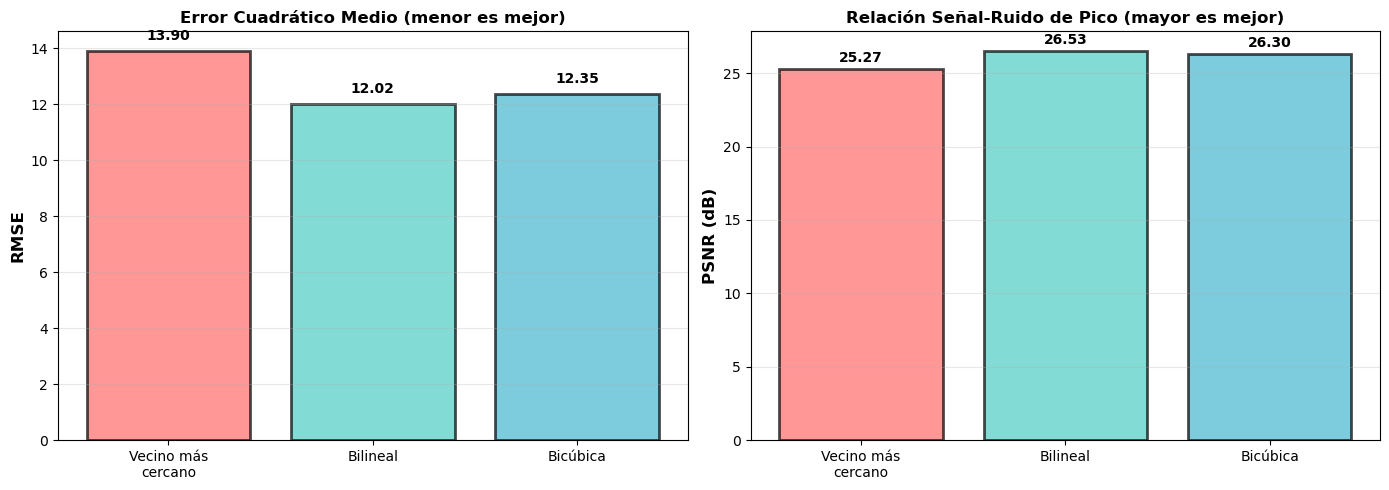


[5/5] Generando ejemplos con efecto combinado...


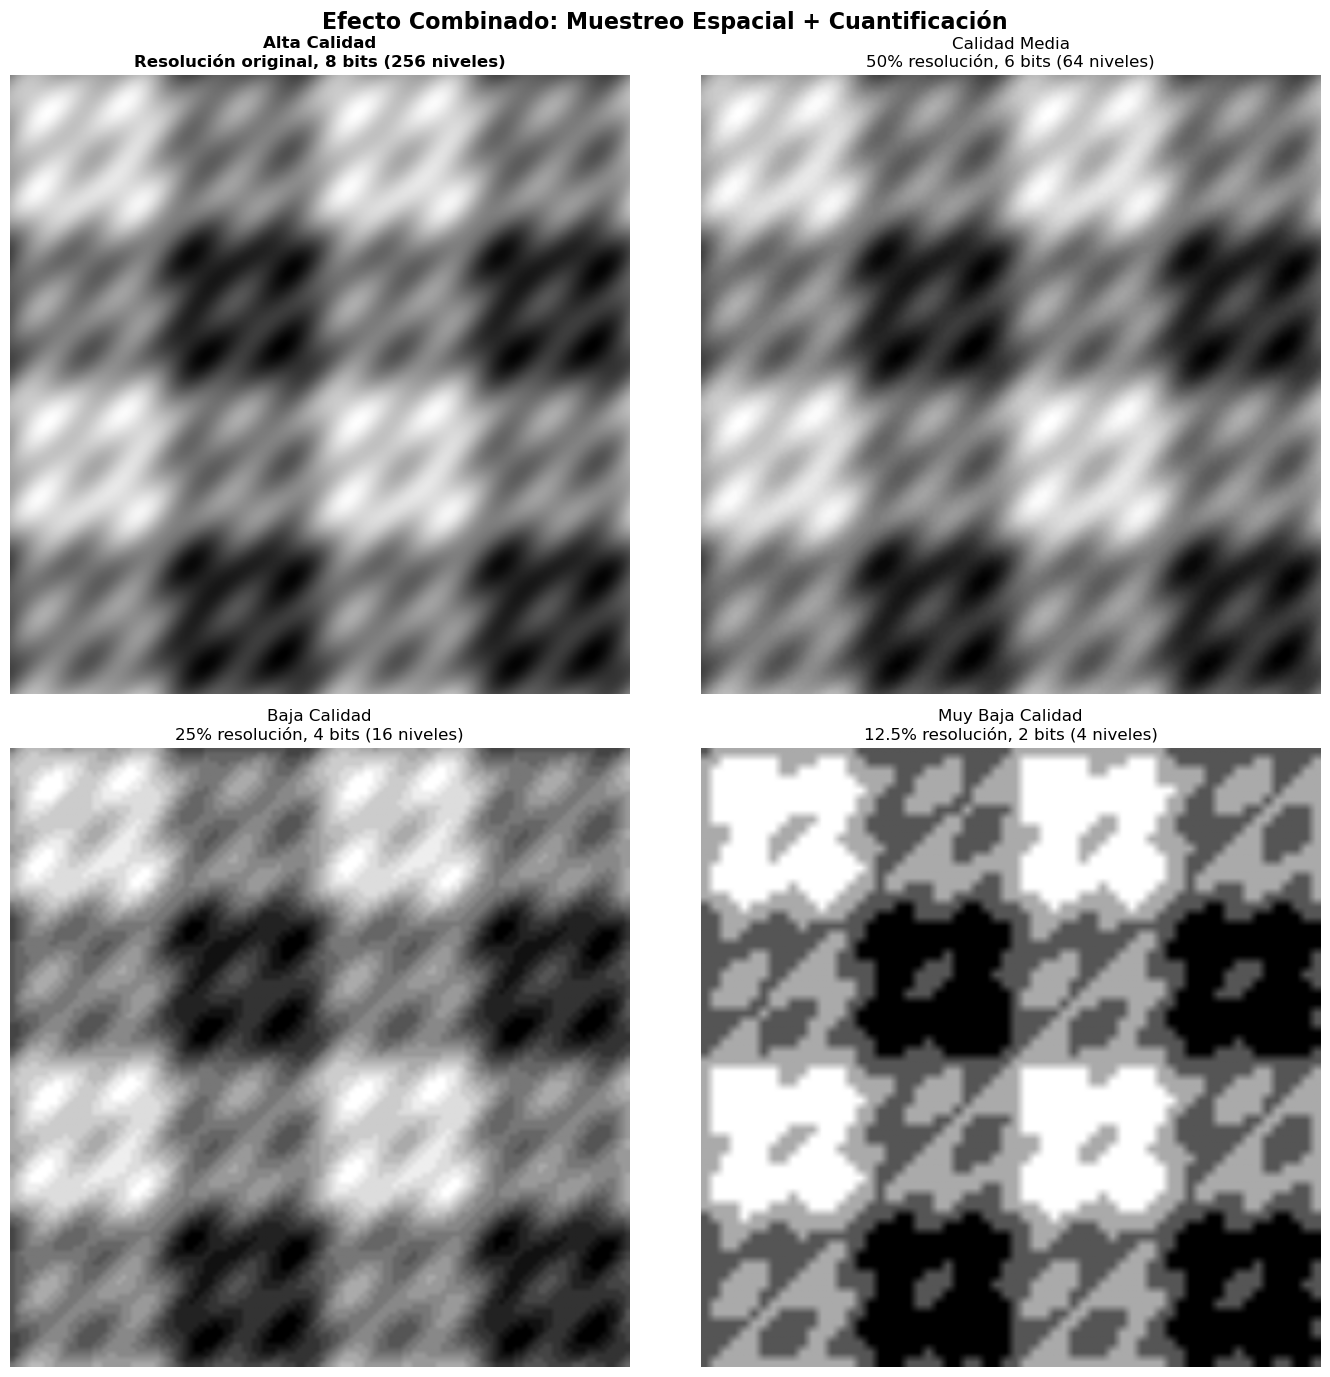


ANÁLISIS COMPLETADO

CONCLUSIONES:

1. Muestreo Espacial:
   - La resolución espacial determina la cantidad de detalle capturado
   - El submuestreo excesivo produce pérdida irreversible de información
   - El aliasing espacial genera patrones falsos (artefactos)

2. Cuantificación:
   - La profundidad de bits determina la suavidad de los gradientes
   - Menos de 6 bits produce posterización visible
   - Es un proceso no lineal con errores de redondeo

3. Reconstrucción:
   - La interpolación bicúbica ofrece la mejor calidad visual
   - Ningún método puede recuperar información perdida
   - Solo puede suavizar, no restaurar detalles originales

4. Teorema de Nyquist en 2D:
   - Se aplica en ambas dimensiones espaciales
   - La frecuencia de muestreo debe ser ≥ 2 × frecuencia espacial máxima
   - Los filtros anti-aliasing son esenciales antes del submuestreo

Todas las visualizaciones se han mostrado correctamente


In [4]:

# Visualizar imagen original
plt.figure(figsize=(8, 8))
plt.imshow(imagen_original, cmap='gray')
titulo = 'Imagen Original' if usar_imagen_propia else 'Imagen Original (Sintética)'
plt.title(f'{titulo}\n{imagen_original.shape[0]}x{imagen_original.shape[1]} píxeles, 8 bits',
          fontsize=14, fontweight='bold')
plt.colorbar(label='Intensidad')
plt.axis('off')
plt.tight_layout()
plt.show()

# ==============================================================================
# 1. MUESTREO ESPACIAL (REDUCCIÓN DE RESOLUCIÓN)
# ==============================================================================

print("\n[1/5] Aplicando muestreo espacial...")

def submuestrear_imagen(imagen, factor):
    """
    Submuestrea una imagen tomando 1 de cada 'factor' píxeles en ambas dimensiones.
    """
    return imagen[::factor, ::factor]

# Aplicar diferentes niveles de submuestreo
factor_2 = 2   # 50% de resolución
factor_4 = 4   # 25% de resolución
factor_8 = 8   # 12.5% de resolución
factor_16 = 16 # 6.25% de resolución

img_sub2 = submuestrear_imagen(imagen_original, factor_2)
img_sub4 = submuestrear_imagen(imagen_original, factor_4)
img_sub8 = submuestrear_imagen(imagen_original, factor_8)
img_sub16 = submuestrear_imagen(imagen_original, factor_16)

print(f"✓ Imagen submuestreada x2: {img_sub2.shape}")
print(f"✓ Imagen submuestreada x4: {img_sub4.shape}")
print(f"✓ Imagen submuestreada x8: {img_sub8.shape}")
print(f"✓ Imagen submuestreada x16: {img_sub16.shape}")

# Visualización del efecto del submuestreo espacial
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(imagen_original, cmap='gray')
axes[0, 0].set_title(f'Original\n{imagen_original.shape[0]}x{imagen_original.shape[1]} píxeles', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_sub2, cmap='gray')
axes[0, 1].set_title(f'Submuestreo x2\n{img_sub2.shape[0]}x{img_sub2.shape[1]} píxeles')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_sub4, cmap='gray')
axes[0, 2].set_title(f'Submuestreo x4\n{img_sub4.shape[0]}x{img_sub4.shape[1]} píxeles')
axes[0, 2].axis('off')

axes[1, 0].imshow(img_sub8, cmap='gray')
axes[1, 0].set_title(f'Submuestreo x8\n{img_sub8.shape[0]}x{img_sub8.shape[1]} píxeles')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_sub16, cmap='gray')
axes[1, 1].set_title(f'Submuestreo x16\n{img_sub16.shape[0]}x{img_sub16.shape[1]} píxeles')
axes[1, 1].axis('off')

axes[1, 2].axis('off')

plt.suptitle('Efecto del Muestreo Espacial (Resolución)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ==============================================================================
# 2. CUANTIFICACIÓN DE NIVELES DE GRIS
# ==============================================================================

print("\n[2/5] Aplicando cuantificación de niveles de gris...")

def cuantificar_imagen(imagen, bits):
    """
    Cuantifica una imagen a un número específico de bits.
    """
    niveles = 2 ** bits
    factor = 256 / niveles
    img_cuantificada = np.floor(imagen / factor) * factor
    return img_cuantificada.astype(np.uint8)

# Aplicar diferentes niveles de cuantificación
img_8bits = imagen_original.copy()  # 256 niveles
img_6bits = cuantificar_imagen(imagen_original, 6)  # 64 niveles
img_4bits = cuantificar_imagen(imagen_original, 4)  # 16 niveles
img_3bits = cuantificar_imagen(imagen_original, 3)  # 8 niveles
img_2bits = cuantificar_imagen(imagen_original, 2)  # 4 niveles
img_1bit = cuantificar_imagen(imagen_original, 1)   # 2 niveles

print(f"✓ 8 bits: {len(np.unique(img_8bits))} niveles únicos")
print(f"✓ 6 bits: {len(np.unique(img_6bits))} niveles únicos")
print(f"✓ 4 bits: {len(np.unique(img_4bits))} niveles únicos")
print(f"✓ 3 bits: {len(np.unique(img_3bits))} niveles únicos")
print(f"✓ 2 bits: {len(np.unique(img_2bits))} niveles únicos")
print(f"✓ 1 bit: {len(np.unique(img_1bit))} niveles únicos")

# Visualización del efecto de la cuantificación
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img_8bits, cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title('8 bits (256 niveles)', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_6bits, cmap='gray', vmin=0, vmax=255)
axes[0, 1].set_title('6 bits (64 niveles)')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_4bits, cmap='gray', vmin=0, vmax=255)
axes[0, 2].set_title('4 bits (16 niveles)')
axes[0, 2].axis('off')

axes[1, 0].imshow(img_3bits, cmap='gray', vmin=0, vmax=255)
axes[1, 0].set_title('3 bits (8 niveles)')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_2bits, cmap='gray', vmin=0, vmax=255)
axes[1, 1].set_title('2 bits (4 niveles)')
axes[1, 1].axis('off')

axes[1, 2].imshow(img_1bit, cmap='gray', vmin=0, vmax=255)
axes[1, 2].set_title('1 bit (2 niveles - binaria)')
axes[1, 2].axis('off')

plt.suptitle('Efecto de la Cuantificación de Niveles de Gris', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ==============================================================================
# 3. RECONSTRUCCIÓN MEDIANTE INTERPOLACIÓN
# ==============================================================================

print("\n[3/5] Reconstruyendo imágenes con diferentes métodos de interpolación...")

def reconstruir_imagen(img_sub, tamaño_original, metodo='bilinear'):
    """
    Reconstruye una imagen submuestreada al tamaño original usando interpolación.
    """
    img_pil = Image.fromarray(img_sub)

    if metodo == 'nearest':
        resample = Image.NEAREST
    elif metodo == 'bilinear':
        resample = Image.BILINEAR
    elif metodo == 'bicubic':
        resample = Image.BICUBIC
    else:
        resample = Image.BILINEAR

    img_reconstruida = img_pil.resize(tamaño_original[::-1], resample=resample)
    return np.array(img_reconstruida)

# Reconstruir la imagen submuestreada x8 con diferentes métodos
tamaño_orig = imagen_original.shape

img_rec_nearest = reconstruir_imagen(img_sub8, tamaño_orig, 'nearest')
img_rec_bilinear = reconstruir_imagen(img_sub8, tamaño_orig, 'bilinear')
img_rec_bicubic = reconstruir_imagen(img_sub8, tamaño_orig, 'bicubic')

print(f"✓ Vecino más cercano: {img_rec_nearest.shape}")
print(f"✓ Bilineal: {img_rec_bilinear.shape}")
print(f"✓ Bicúbica: {img_rec_bicubic.shape}")

# Visualización de métodos de interpolación
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].imshow(imagen_original, cmap='gray')
axes[0, 0].set_title(f'Imagen Original ({imagen_original.shape[0]}x{imagen_original.shape[1]})',
                     fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_rec_nearest, cmap='gray')
axes[0, 1].set_title(f'Reconstrucción: Vecino más cercano\n(desde {img_sub8.shape[0]}x{img_sub8.shape[1]})',
                     fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(img_rec_bilinear, cmap='gray')
axes[1, 0].set_title(f'Reconstrucción: Interpolación bilineal\n(desde {img_sub8.shape[0]}x{img_sub8.shape[1]})',
                     fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(img_rec_bicubic, cmap='gray')
axes[1, 1].set_title(f'Reconstrucción: Interpolación bicúbica\n(desde {img_sub8.shape[0]}x{img_sub8.shape[1]})',
                     fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('Comparación de Métodos de Interpolación', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ==============================================================================
# 4. ANÁLISIS DE ERRORES DE RECONSTRUCCIÓN
# ==============================================================================

print("\n[4/5] Calculando métricas de error...")

def calcular_metricas(img_original, img_reconstruida):
    """
    Calcula métricas de error entre la imagen original y la reconstruida.
    """
    mse = np.mean((img_original.astype(float) - img_reconstruida.astype(float)) ** 2)
    rmse = np.sqrt(mse)

    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(255.0 / rmse)

    return mse, rmse, psnr

# Calcular métricas para cada método
mse_nearest, rmse_nearest, psnr_nearest = calcular_metricas(imagen_original, img_rec_nearest)
mse_bilinear, rmse_bilinear, psnr_bilinear = calcular_metricas(imagen_original, img_rec_bilinear)
mse_bicubic, rmse_bicubic, psnr_bicubic = calcular_metricas(imagen_original, img_rec_bicubic)

print("\n=== Métricas de Error de Reconstrucción ===")
print("\nVecino más cercano:")
print(f"  MSE: {mse_nearest:.2f}")
print(f"  RMSE: {rmse_nearest:.2f}")
print(f"  PSNR: {psnr_nearest:.2f} dB")

print("\nInterpolación bilineal:")
print(f"  MSE: {mse_bilinear:.2f}")
print(f"  RMSE: {rmse_bilinear:.2f}")
print(f"  PSNR: {psnr_bilinear:.2f} dB")

print("\nInterpolación bicúbica:")
print(f"  MSE: {mse_bicubic:.2f}")
print(f"  RMSE: {rmse_bicubic:.2f}")
print(f"  PSNR: {psnr_bicubic:.2f} dB")

print("\nNota: Mayor PSNR indica mejor calidad de reconstrucción")

# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metodos = ['Vecino más\ncercano', 'Bilineal', 'Bicúbica']
rmse_values = [rmse_nearest, rmse_bilinear, rmse_bicubic]
psnr_values = [psnr_nearest, psnr_bilinear, psnr_bicubic]
colores = ['#ff6b6b', '#4ecdc4', '#45b7d1']

# RMSE
axes[0].bar(metodos, rmse_values, color=colores, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Error Cuadrático Medio (menor es mejor)', fontsize=12, fontweight='bold')
axes[0].grid(True, axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0].text(i, v + max(rmse_values)*0.02, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# PSNR
axes[1].bar(metodos, psnr_values, color=colores, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
axes[1].set_title('Relación Señal-Ruido de Pico (mayor es mejor)', fontsize=12, fontweight='bold')
axes[1].grid(True, axis='y', alpha=0.3)
for i, v in enumerate(psnr_values):
    axes[1].text(i, v + max(psnr_values)*0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ==============================================================================
# 5. EFECTO COMBINADO: MUESTREO + CUANTIFICACIÓN
# ==============================================================================

print("\n[5/5] Generando ejemplos con efecto combinado...")

# Crear imágenes con diferentes combinaciones de muestreo y cuantificación
img_alta_calidad = cuantificar_imagen(imagen_original, 8)  # Original, 8 bits

img_media_calidad = submuestrear_imagen(imagen_original, 2)  # 50% resolución
img_media_calidad = cuantificar_imagen(img_media_calidad, 6)  # 6 bits
img_media_calidad = reconstruir_imagen(img_media_calidad, tamaño_orig, 'bilinear')

img_baja_calidad = submuestrear_imagen(imagen_original, 4)  # 25% resolución
img_baja_calidad = cuantificar_imagen(img_baja_calidad, 4)  # 4 bits
img_baja_calidad = reconstruir_imagen(img_baja_calidad, tamaño_orig, 'bilinear')

img_muy_baja = submuestrear_imagen(imagen_original, 8)  # 12.5% resolución
img_muy_baja = cuantificar_imagen(img_muy_baja, 2)  # 2 bits
img_muy_baja = reconstruir_imagen(img_muy_baja, tamaño_orig, 'bilinear')

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].imshow(img_alta_calidad, cmap='gray')
axes[0, 0].set_title('Alta Calidad\nResolución original, 8 bits (256 niveles)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_media_calidad, cmap='gray')
axes[0, 1].set_title('Calidad Media\n50% resolución, 6 bits (64 niveles)', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(img_baja_calidad, cmap='gray')
axes[1, 0].set_title('Baja Calidad\n25% resolución, 4 bits (16 niveles)', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(img_muy_baja, cmap='gray')
axes[1, 1].set_title('Muy Baja Calidad\n12.5% resolución, 2 bits (4 niveles)', fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('Efecto Combinado: Muestreo Espacial + Cuantificación', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ==============================================================================
# RESUMEN FINAL
# ==============================================================================

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO")
print("="*70)

print("\nCONCLUSIONES:")
print("\n1. Muestreo Espacial:")
print("   - La resolución espacial determina la cantidad de detalle capturado")
print("   - El submuestreo excesivo produce pérdida irreversible de información")
print("   - El aliasing espacial genera patrones falsos (artefactos)")

print("\n2. Cuantificación:")
print("   - La profundidad de bits determina la suavidad de los gradientes")
print("   - Menos de 6 bits produce posterización visible")
print("   - Es un proceso no lineal con errores de redondeo")

print("\n3. Reconstrucción:")
print("   - La interpolación bicúbica ofrece la mejor calidad visual")
print("   - Ningún método puede recuperar información perdida")
print("   - Solo puede suavizar, no restaurar detalles originales")

print("\n4. Teorema de Nyquist en 2D:")
print("   - Se aplica en ambas dimensiones espaciales")
print("   - La frecuencia de muestreo debe ser ≥ 2 × frecuencia espacial máxima")
print("   - Los filtros anti-aliasing son esenciales antes del submuestreo")

print("\n" + "="*70)
print("Todas las visualizaciones se han mostrado correctamente")
print("="*70)
